<h1><center> What's in a Hit Pop Song? <br> Looking into the Lyrics of Grammy Recognized Pop Songs <br>From 2012-2018 (Beautiful Soup/Regex) </center></h1>
<img src="https://www.grammy.com/sites/com/files/styles/news_detail_header/public/wireimage-138864306.jpg?itok=x3lGnKB7" alt="Adele" title="Adele Grammys" />
<h3><center>Adele is deservedly the queen of modern pop. She leads as the artist with the most wins, four, of the "Grammy Award for Best Pop Solo Performance."</center></h3>
## Introduction
The Grammy's is a celebration of the most well-recognized works in the commercial music industry. In a sense, many could say that the Grammy's recognizes the achievements of exclusively pop songs, songs that are popular enough to be recognized by most of those who tune into the awards show, but in this notebook I will be focusing not only on the genre of "Pop" music, but what constitutes critically-acclaimed pop music at the lyrical level. Though I am by no means a Pop aficionado, I set up this challenge for myself to showcase my ability to webscrape data with BeautifulSoup and transform it using regular expressions and tfidf vectorization. The musiXmatch api would have been an easy way to pull lyrics from songs had it not been for its $1,000 monthly fee for complete access (the free version only returns 30 percent of the lyrics for a queried song). Thankfully, I was able to exploit the simple web format of "azlyrics" to pull the lyrics I needed for this project.

In [354]:
# import libraries
import pandas as pd
import numpy as np
import requests
import urllib
from bs4 import BeautifulSoup
#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

#nltk.download()
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()
eng_stopwords = set(stopwords.words("english"))

# Webscraping Wikipedia With BeautifulSoup
<img src="https://i.imgur.com/Ng3u4h7.png" alt="wiki" title="wiki" width="650"/>

Wikipedia contains a visually neat table of winners and nominees of Grammy awards. I was able to obtain all the pertinent information by accessing the anchor tags of the table that redirects the viewer to another wikipedia page. For the most part, there was only a single anchor tag for year, song, and artist.

In [163]:
# open wikipedia link for pop awards
url = 'https://en.wikipedia.org/wiki/Grammy_Award_for_Best_Pop_Solo_Performance'
f = urllib.urlopen(url)
html_grammy = f.read()
grammy_parser = BeautifulSoup(html_grammy, 'lxml')

grammy_years=np.arange(2012,2019,1)

#access the table containing grammy award wins and nominations
grammy_pop_data=grammy_parser.find("table", {"class":"wikitable sortable"}).find_all('a')

grammy_string =""

for i in grammy_pop_data:
    grammy_string += i.get_text() + " "

# regex to access blocks of table by year    
grammy_regex = re.compile(r"20[\s\w'\(\)\\\d]*", re.UNICODE)
grammy_matches = grammy_regex.finditer(grammy_string)

for match in grammy_matches:
    print match.group()

2012 Adele  Someone Like You You and I Lady Gaga Grenade Bruno Mars Firework Katy Perry Fuckin' Perfect Pink 
2013 Set Fire to the Rain Stronger (What Doesn't Kill You) Kelly Clarkson Call Me Maybe Carly Rae Jepsen Wide Awake Katy Perry Where Have You Been Rihanna 
2014 Lorde  Royals Brave Sara Bareilles When I Was Your Man Bruno Mars Roar Katy Perry Mirrors Justin Timberlake 
2015 Pharrell Williams  Happy All of Me John Legend Chandelier Sia Stay with Me Darkchild Sam Smith Shake It Off Taylor Swift 
2016 Ed Sheeran  Thinking Out Loud Heartbeat Song Kelly Clarkson Love Me Like You Do Ellie Goulding Blank Space Taylor Swift Can't Feel My Face The Weeknd 
2017 Adele  Hello Hold Up Beyoncé Love Yourself Justin Bieber Piece by Piece Idol Kelly Clarkson Dangerous Woman Ariana Grande 
2018 Ed Sheeran  Shape of You Love So Soft Kelly Clarkson Praying Kesha Million Reasons Lady Gaga What About Us Pink 


In [243]:
grammy_pop_data=grammy_parser.find("table", {"class":"wikitable sortable"}).find_all('a')


grammy_list=[]

for i in grammy_pop_data:
    #exceptions (beautifulsoup captures anchor tags in html, some songs have 2 anchors for additional details)
    if i.get_text() == "":
        continue
    if i.get_text() == "Darkchild":
        continue
    if i.get_text() == "Idol":
        continue
    if i.get_text() == "2013":
        grammy_list.append(i.get_text())
        grammy_list.append("Adele")
    else:
        grammy_list.append(i.get_text())

# capture all grammy_years
grammy_years=[]
for i in [1+i*12 for i in np.arange(0,7,1)]:
    grammy_years.append(str(grammy_list[i]))
grammy_years=np.repeat(grammy_years,5)

#capture grammy_artists
grammy_artists=[]
for artist in [t+i*12 for i in np.arange(0,7,1) for t in [2,5,7,9,11]]:
    grammy_artists.append(grammy_list[artist])
    
#capture grammy_songs
grammy_songs=[]
for song in [t+i*12 for i in np.arange(0,7,1) for t in [3,4,6,8,10]]:
    grammy_songs.append(grammy_list[song])
    
grammy_df=pd.concat([pd.Series(grammy_years), pd.Series(grammy_artists), pd.Series(grammy_songs)], axis=1)
grammy_df.columns = ['year','artist','song']
# add grammy winners
grammy_winners_df=grammy_df.groupby(['year']).first()
grammy_winners_df['winner']=1
grammy_df=grammy_df.merge(grammy_winners_df, on=['artist','song'],how='left').fillna(0)

In [246]:
grammy_df.head()

,year,artist,song,winner
0,2012,Adele,Someone Like You,1.0
1,2012,Lady Gaga,You and I,0.0
2,2012,Bruno Mars,Grenade,0.0
3,2012,Katy Perry,Firework,0.0
4,2012,Pink,Fuckin' Perfect,0.0


# Webscraping AZ Lyrics With Beautiful Soup

<img src="https://i.imgur.com/LHHBaVw.png" alt="lyrics" title="lyrics" width="650"/>

Pulling the lyrics from azlyrics.com was a much easier task due to the information not being stored in a table with occasionally multiple points being associated with a single piece of data. The simple html format allowed me to exploit a comment in the code which preceded the lyrics. The lyrics were also scrubbed of any annotations, such as "[Chorus :]", which weren't relevant to the song itself for the intents and purposes of this notebook. There were 4 exceptions where pulling the lyrics resulted in an error. These errors were caused by azlyrics classifying the artist as a name different than his or her stage name (i.e. Beyonce as "Beyonce Knowles").

In [283]:
#function to return lyrics
regex_banner = r"<!--\sUsage[\S\s]*banner\s-->"
#remove annotations in lyrics
regex_annotations = r"(\[[\S\s]{1,30}\])"

def retrieve_lyrics(artist_raw,song_raw):
    artist = artist_raw.lower().replace(" ","").replace("'","")
    song = song_raw.lower().replace(" ","").replace("'","")
    try:
        url_lyrics = 'https://www.azlyrics.com/lyrics/{}/{}.html'.format(artist,song)
        html_lyrics = urllib.urlopen(url_lyrics).read()
        parser_lyrics = BeautifulSoup(html_lyrics, 'lxml')
        m = re.search(regex_banner, str(parser_lyrics))
        m1 = BeautifulSoup(m.group(0)).get_text().replace('\n',' ')
        result = re.sub(regex_annotations, "", m1, 20)
        return result
    except:
        return "ERROR"

#example
retrieve_lyrics('Adele',"Someone Like You")

u'I heard that you\'re settled down That you found a girl and you\'re married now. I heard that your dreams came true. Guess she gave you things I didn\'t give to you.  Old friend, why are you so shy? Ain\'t like you to hold back or hide from the light.  I hate to turn up out of the blue uninvited But I couldn\'t stay away, I couldn\'t fight it. I had hoped you\'d see my face and that you\'d be reminded That for me it isn\'t over.  Never mind, I\'ll find someone like you I wish nothing but the best for you too Don\'t forget me, I beg I\'ll remember you said, "Sometimes it lasts in love but sometimes it hurts instead, Sometimes it lasts in love but sometimes it hurts instead"  You know how the time flies Only yesterday was the time of our lives We were born and raised In a summer haze Bound by the surprise of our glory days  I hate to turn up out of the blue uninvited But I couldn\'t stay away, I couldn\'t fight it. I\'d hoped you\'d see my face and that you\'d be reminded That for me i

In [265]:
# retrieve lyrics
grammy_lyrics=[]
for index, row in grammy_df.iterrows():
    grammy_lyrics.append(retrieve_lyrics(row['artist'],row['song']))
    
grammy_df['lyrics']=grammy_lyrics
#look up errors
grammy_df[grammy_df['lyrics']=='ERROR']

,year,artist,song,winner,lyrics
6,2013,Kelly Clarkson,Stronger (What Doesn't Kill You),0.0,ERROR
24,2016,The Weeknd,Can't Feel My Face,0.0,ERROR
26,2017,Beyoncé,Hold Up,0.0,ERROR
32,2018,Kesha,Praying,0.0,ERROR


In [279]:
#fill errors manually
grammy_df.loc[(grammy_df.artist=='Kelly Clarkson')&(grammy_df['lyrics']=='ERROR'),'lyrics']=retrieve_lyrics('kellyclarkson','whatdoesntkillyoustronger')
grammy_df.loc[(grammy_df.artist=='The Weeknd')&(grammy_df['lyrics']=='ERROR'),'lyrics']=retrieve_lyrics('weeknd','icantfeelmyface')
#fix beyonce name
grammy_df.iloc[26,1]='Beyonce'
grammy_df.loc[(grammy_df.artist=='Beyonce')&(grammy_df['lyrics']=='ERROR'),'lyrics']=retrieve_lyrics('beyonceknowles','holdup')
grammy_df.loc[(grammy_df.artist=='Kesha')&(grammy_df['lyrics']=='ERROR'),'lyrics']=retrieve_lyrics('keha','praying')


# TFIDF Vectorization

<img src="https://image.slidesharecdn.com/vectorization20140915-140916135606-phpapp02/95/intro-to-vectorization-concepts-gatech-cse6242-13-638.jpg?cb=1410875842" alt="tfidf" title="tfidf" width="650"/>
With a complete set of lyrics, the next step is to clean these lyrics up and process them into word vectors. My method of pre-processing is as follows: turn contractions into their constituent words, remove any special symbols, lemmatize the words (only select words that appear in a dictionary and form word roots/i.e. running to run), and remove commonly used words a.k.a stop word removal. With the lyrics cleaned, I then decided to process them with tfidf vectorization, which returns relative word frequencies within the body of lyrics. The end result is a word vector representation of the lyrics to each song, where vectors can range from a single word to pairs of words to triplets of words. 

In [293]:
#dictionary of apostrophe words
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

In [315]:
def initial_clean(raw_lyrics):
    # split words and lowercase
    words = raw_lyrics.lower().split() 
    # convert contractions into individual words
    words=[APPO[word] if word in APPO else word for word in words]
    # join words
    words=" ".join(words)
    # return only words
    letters_only = re.sub("[^a-zA-Z]", " ", words)
    words=tokenizer.tokenize(letters_only)
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    clean_sent=" ".join(words)

    
    return clean_sent

#create cleaned lyrics column
grammy_df['cleaned_lyrics']=grammy_df['lyrics'].apply(initial_clean)

In [326]:
clean_corpus = grammy_df.cleaned_lyrics
tf_vectorizer = TfidfVectorizer(max_df=0.95,min_df=0.001,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,3),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tf = tf_vectorizer.fit_transform(clean_corpus)
features=np.array(tf_vectorizer.get_feature_names())
print features
print len(features)

[u'abandon' u'abandon know' u'abandon know love' ..., u'zero' u'zero hero'
 u'zero hero hold']
6254


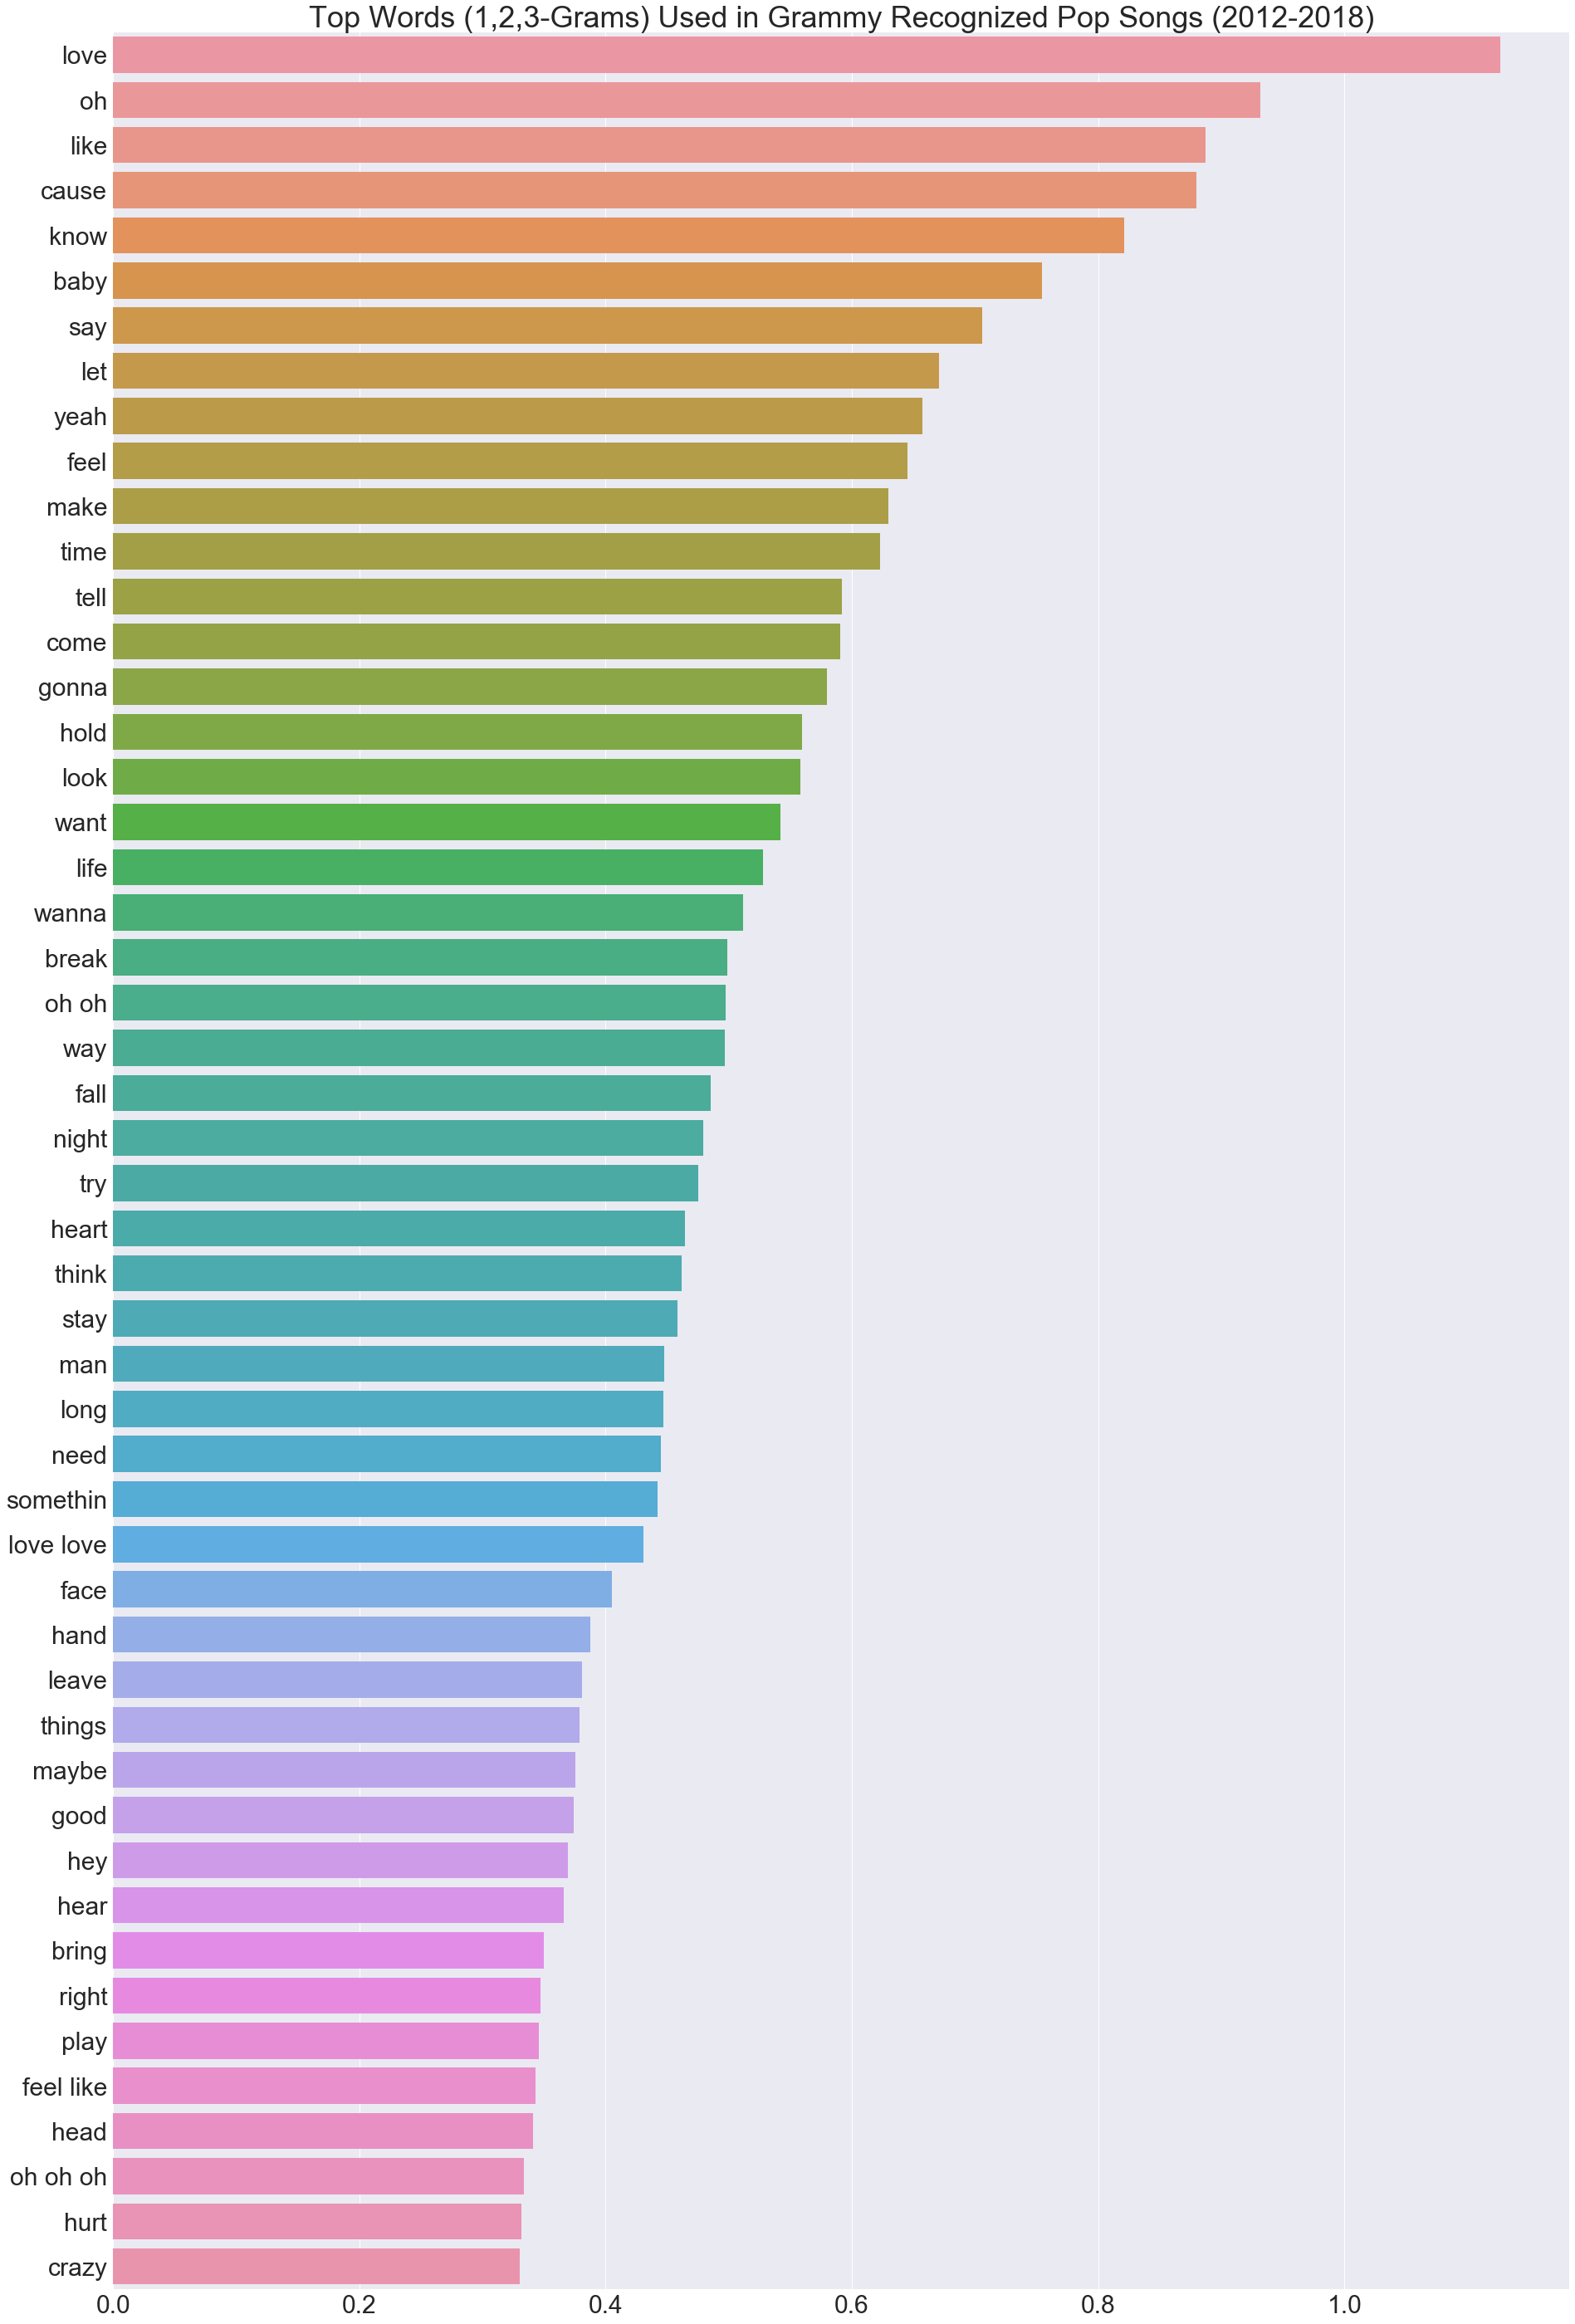

In [349]:
df_12g = pd.DataFrame(tf.toarray(),columns=features)

sns.set(font_scale=3)
plt.figure(figsize=(28,50))
plt.title("Top Words (1,2,3-Grams) Used in Grammy Recognized Pop Songs (2012-2018)")
sns.barplot(y=df_12g.sum().sort_values(ascending=False)[:50].index,\
            x=df_12g.sum().sort_values(ascending=False)[:50],orient='h')

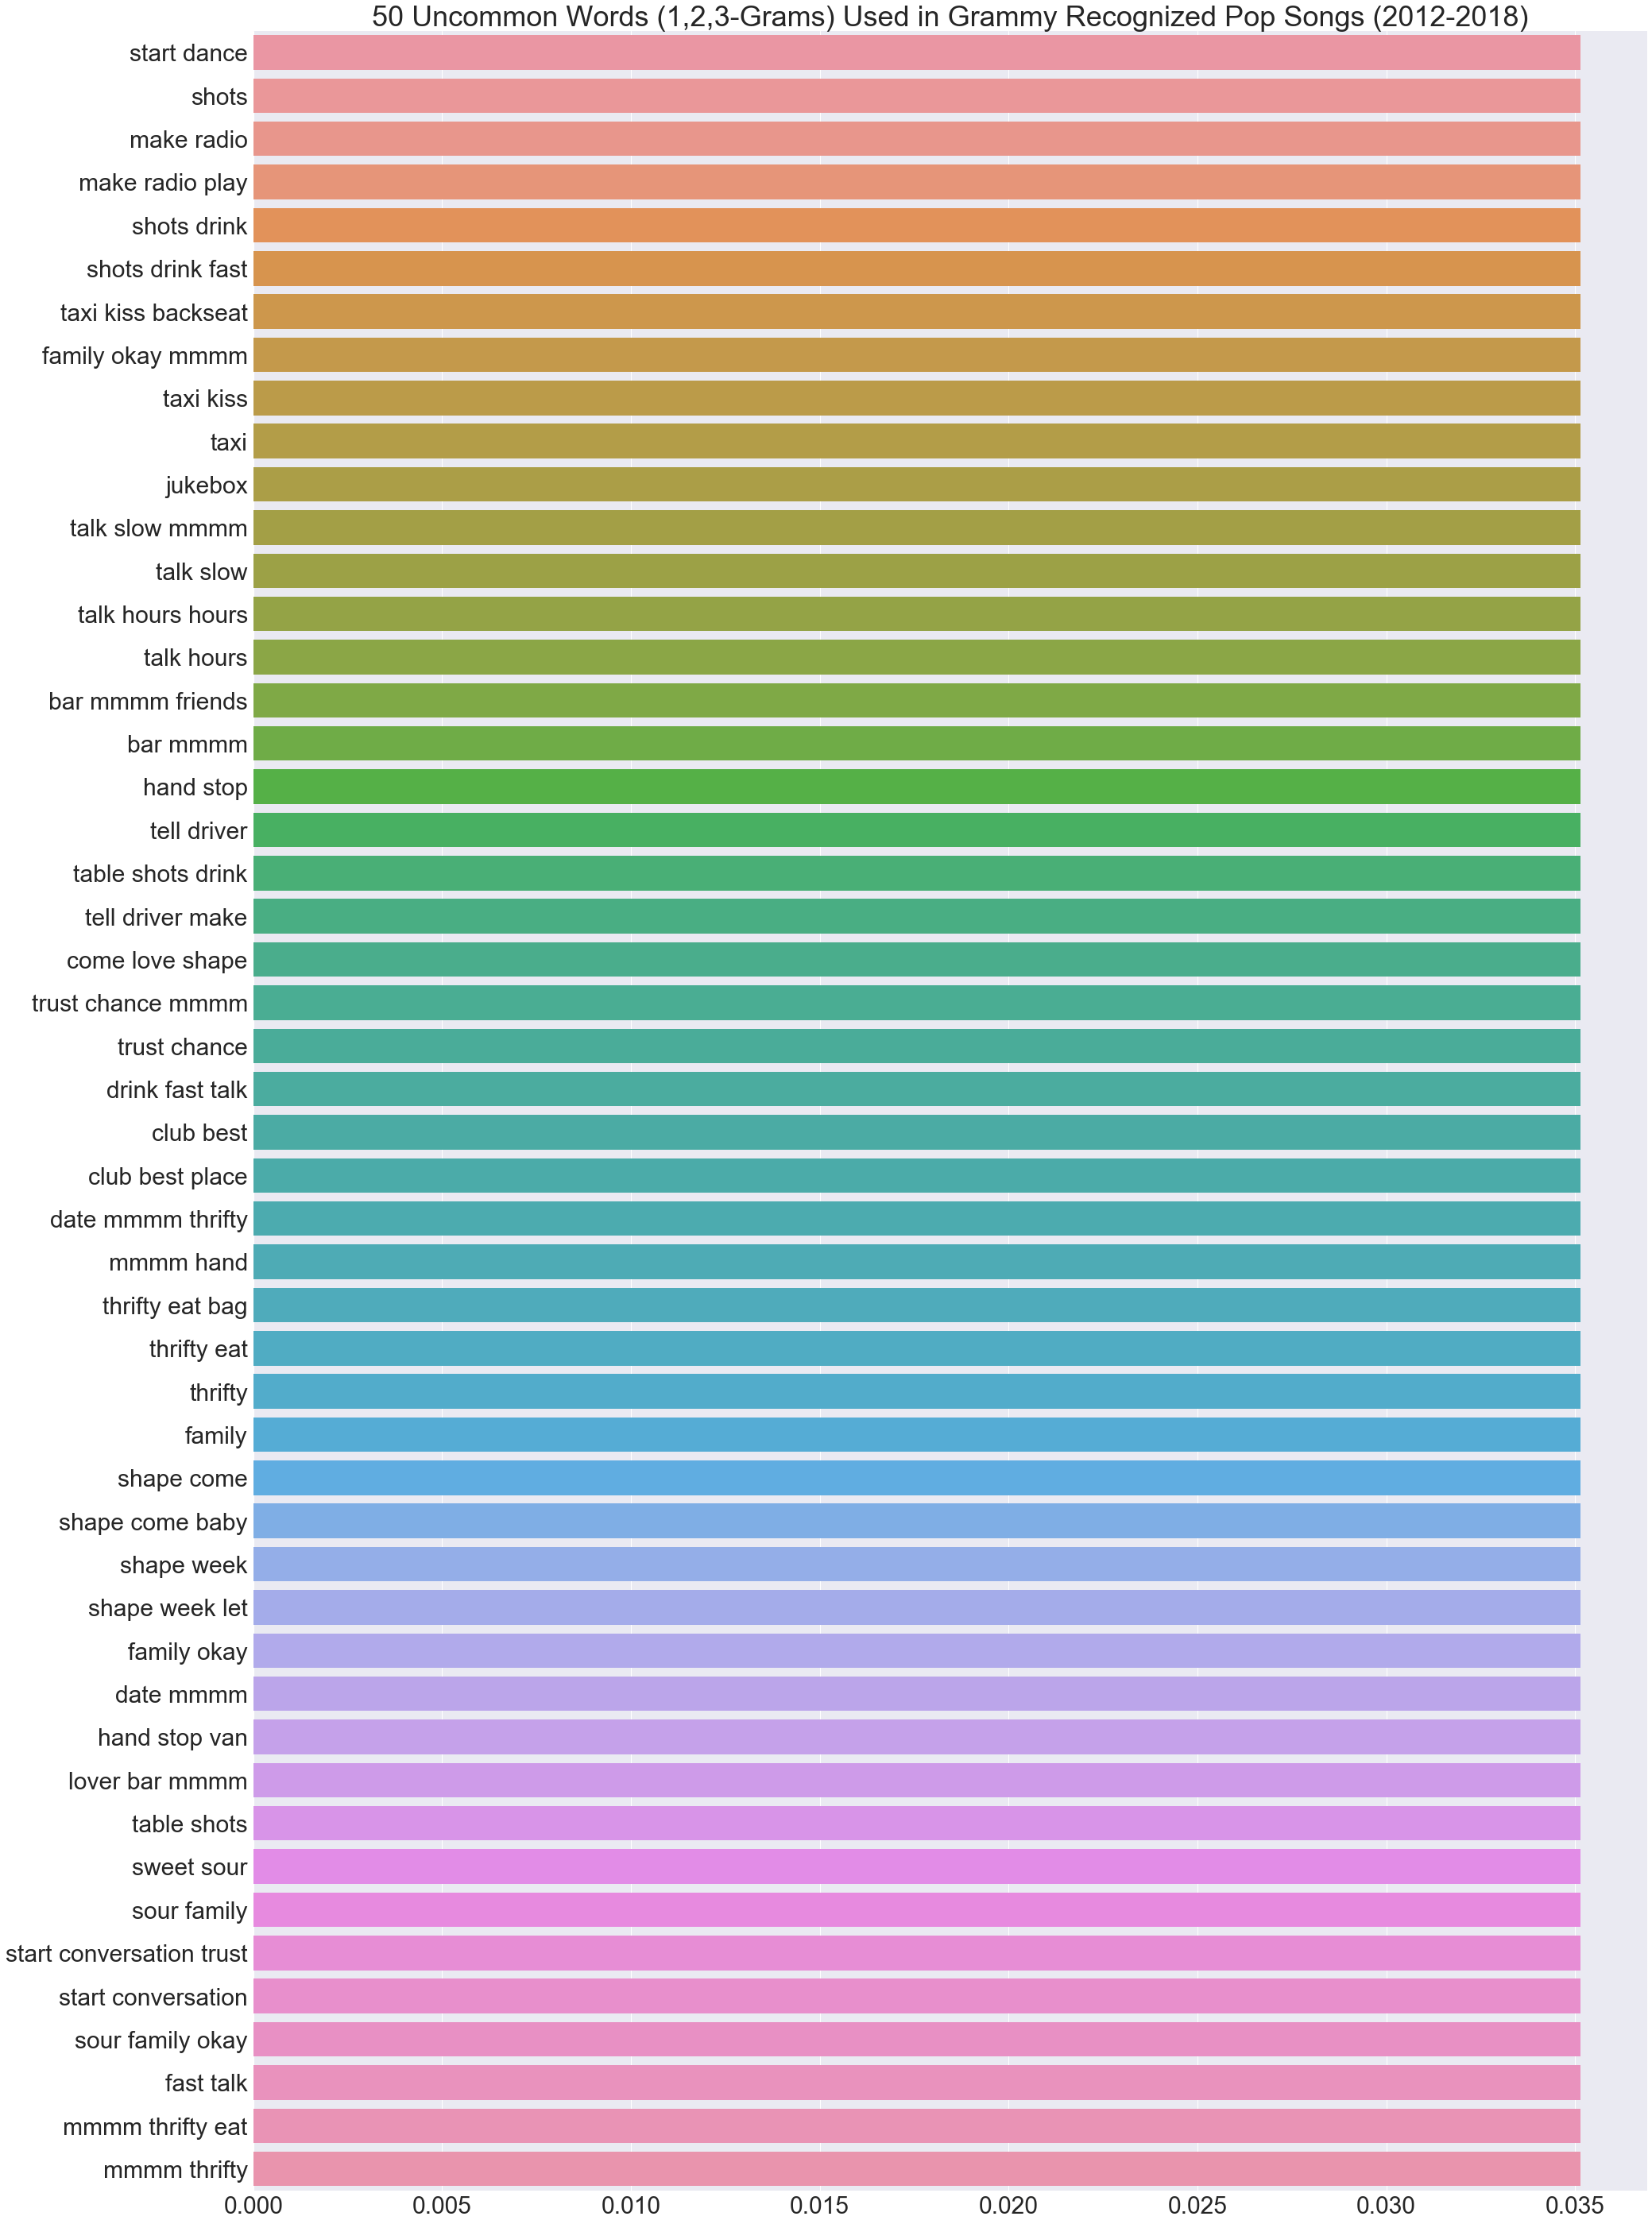

In [353]:
sns.set(font_scale=3)
plt.figure(figsize=(28,50))
plt.title("50 Uncommon Words (1,2,3-Grams) Used in Grammy Recognized Pop Songs (2012-2018)")
sns.barplot(y=df_12g.sum().sort_values()[:50].index,\
            x=df_12g.sum().sort_values()[:50],orient='h')

# Commentary
It comes as no surprise that themes of romance ("love","baby","night","hold") were the most common features in all recognized pop songs. On the other hand, I did find it amusing that features relating to family ("family","sour family") scored low. I guess this suggests or reinforces the notion that pop music is targetted toward younger audiences: those who aren't involved in family matters, other than those with their parents and siblings, and who are still looking for their significant other, or maybe heartbroken by those that they thought was the "one." Of course this sample of 35 songs is too small to be representative of modern pop music as a whole. A more complete representation would be to take the pop songs Billboard Top 100 and analyze the contents of their lyrics. This notebook's purpose, however, was to look at critically acclaimed pop songs, those of which only count to 35 as the Grammy Award for the genre is a recent invention.